In [1]:
import ROOT
import warnings

import numpy as np
import matplotlib.pyplot as plt

from scipy import integrate
from lmfit import Parameters, minimize

from scipy.optimize import curve_fit
from tqdm import tqdm

from scipy.signal import fftconvolve
from scipy.special import gamma

warnings.filterwarnings('ignore')

# Width of the resonance in keV
width = 0.200
width_err = 0.200

# Boltzmann constant in keV/K
k = 8.617e-5

# Doppler effect
dopp = np.sqrt( 2 * 1.007 / 27 * 1.587 * k * ( 80 + 273 ) )
print( 'Doppler effect:', dopp )

Doppler effect: 0.06000697215237205


In [2]:
import stragg

import sys
stdout = sys.stdout

class Straggling:

    emGraph   = ROOT.TGraph( )
    gvGraph   = ROOT.TGraph( )
    vvGraph   = ROOT.TGraph( )
    demGraph  = ROOT.TGraph( )
    betaGraph = ROOT.TGraph( )
    xiGraph   = ROOT.TGraph( )
    kGraph    = ROOT.TGraph( )

    landau       = stragg.LandauFunction( )
    gauss        = stragg.GaussFunction( )
    vavilovAiry  = stragg.VavilovAiryFunction( )
    vavilovMoyal = stragg.VavilovMoyalFunction( )
    vavilovEdgew = stragg.VavilovEdgeworthFunction( )

    def __init__( self, element, energy ):
        self.energy = energy
        self.layer = stragg.Layer( element )

    def get_stopping_power( self, energy ):
        return self.layer.EvaluateZiegler( energy )

    def prepare( self ):

        self.vvGraph.AddPoint( -100, 0 )
        self.vvGraph.AddPoint( 0, 0 )

        em   = self.energy
        gv   = 0
        vv   = 0
        dem  = 0
        xi   = 0
        k    = 0

        self.layer.setThicknessStep( 0.1 )

        while ( (self.energy - em) < 50 ):

            deml = self.layer.GetDEML(em)
            gvl  = self.layer.GetGVL(em)
            vvl  = self.layer.GetVVL(em)
            kl   = self.layer.GetK(em)
            beta = self.layer.GetBeta(em)
            xil  = self.layer.GetXi(em)

            em  -= deml
            dem += deml
            k   += kl
            gv = np.sqrt(gv*gv + gvl*gvl)
            vv = np.sqrt(vv*vv + vvl*vvl)
            xi = xi + xil

            self.emGraph.AddPoint( dem, em )
            self.demGraph.AddPoint( dem, dem )
            self.kGraph.AddPoint( dem, k )
            self.gvGraph.AddPoint( dem, gv )
            self.vvGraph.AddPoint( dem, vv )
            self.xiGraph.AddPoint( dem, xi )
            self.betaGraph.AddPoint( dem, beta )


strag = Straggling( 13, 1587 )
strag.prepare( )

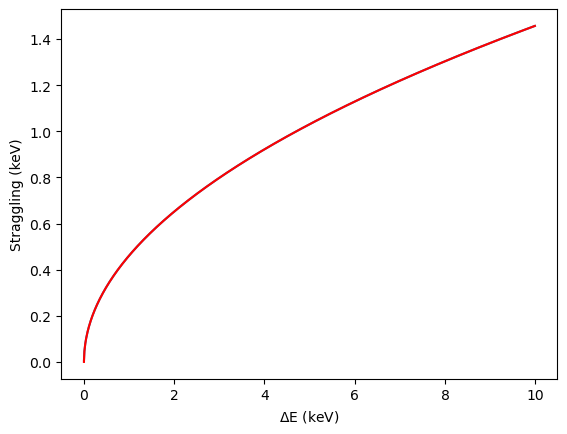

In [3]:
npoints = 1000

x = np.zeros( ( npoints ) )
y = np.zeros( ( npoints ) )

for i in range( npoints ):
    x[i] = i * 0.01
    y[i] = strag.gvGraph.Eval( i * 0.01 )

plt.plot( x, y )

plt.ylabel( 'Straggling (keV)' )
plt.xlabel( r'$\Delta$E (keV)' )

def func( x, a ):
    return a * np.sqrt( x )

popt, pcov = curve_fit( func, x, y )

mod = func( x, *popt )

def straggling( x ):
    return popt[0] * np.sqrt( x )

plt.plot( x, straggling( x ), 'r' )

plt.show( )

In [4]:
# Load the data skipping the header
data = np.loadtxt( 'data/Data_1587_2023.txt', skiprows=1 )
x, obs, err = data[:,0], data[:,1], data[:,2]

In [5]:
# Gamma function for the straggling
def gamma_function(x, a, b):
    return (b**a) * (x**(a-1)) * np.exp(-b*x) / gamma(a)

# Dirac delta function
def delta_dirac(x, x0):
    idx = (np.abs(x - x0)).argmin()
    return np.zeros_like(x) + (x == x[idx]) * 1e6

# Gaussian kernel
def gaussian_kernel(size, sigma, dx):
    # size = number of points in the kernel
    xg = np.linspace(-size // 2, size // 2, size) * dx
    kernel = np.exp(-xg**2 / (2 * sigma**2))
    return kernel / kernel.sum(), xg

# Smooth step function
def smooth_step(x, k=60, x0=0.1):
    return 1 / (1 + np.exp(-k * (x - x0)))

# Function to convolve the straggling with a Gaussian
def convolve(de, sigma):

    if de > 0:
        # Original x-array and function
        x = np.linspace(0.01, 5, 5000)
        s = straggling( de )
        dx = x[1] - x[0]  # spacing
        a = de**2 / s**2
        b = de / s**2
        f = gamma_function( x, a, b )
    else:
        x = np.linspace(-1, 1, 1000)
        dx = x[1] - x[0]  # spacing
        f = delta_dirac( x, de )

    # Create the kernel
    kernel_size = 1000
    g, xg = gaussian_kernel(kernel_size, sigma, dx)

    # Full convolution
    convolved = fftconvolve(f, g, mode='full')

    # New x-axis after convolution
    x_full = np.linspace(
        x[0] + xg[0],
        x[-1] + xg[-1],
        len(convolved)
    )

    return x_full, convolved

In [6]:
def sigma( de ):
    if( de > 0 ):
        return straggling( de )
    else:
        return 0

def gaussian( x, x0, s ):
    return ( 1. / ( np.sqrt(2.*np.pi) * s ) ) * np.exp( -(x - x0)**2 / ( s*s*2 ) )

def stoichiometry( x, theta ):
    nlayers = int( ( len( theta ) - 3 ) / 2 )
    if( nlayers == 1 ): return theta[3]
    else:
        norms = smooth_step( x, k=theta[6], x0=theta[4] )
        return theta[3] * ( 1 - norms ) + theta[5] * norms

def cross_section( x0, theta, de ):
    norm = stoichiometry( de, theta )
    return theta[1] / ( ( de - x0 )**2 + ( theta[1] / 2 )**2 ) * norm

def integrand( x, theta, x0 ):
    de, de_res = x0 - x, x0 - theta[2]
    
    # Get beam width
    s = np.sqrt( pow( theta[0], 2 ) + pow( dopp, 2 ) )

    # Convolve the gaussian with the straggling
    array, gauss = convolve( de, s )

    # Normalize the gaussian
    step = array[1] - array[0]
    norm  = np.sum( gauss ) * step
    
    # Convolve
    conv = np.sum( gauss * cross_section( array, theta, de_res ) ) * step / norm

    return conv

def straggled_profile( x, theta ):
    y = np.zeros( shape=len( x ) )
    for idx in range( len( x ) ):
        xmin, xmax = x[idx] - 5, x[idx]
        nsteps = 100
        dx = np.abs( xmax - xmin ) / nsteps
        y[idx] = integrate.simpson( [ integrand( x_i, theta, x[idx] ) for x_i in np.linspace( xmin, xmax, nsteps) ], dx=dx )
    return y

def model( x, theta ):
    sign = straggled_profile( x, theta[:-1] )
    back = theta[-1]
    return sign + back

def chi2( theta ):
    theta = list( theta.valuesdict().values() )
    mod   = model( x, theta )
    res   = ( obs - mod ) / err
    print( "Chi2: {:10.4f}".format(np.sum(res**2)), end="\r" )
    return res

In [7]:
params = Parameters()
params.add('beam',     value=0.07,     vary=False)
params.add('width',    value=0.02,     vary=True)
params.add('edge1',    value=1571.93,  vary=True)
params.add('height1',  value=0.22,     vary=True, min=0)
params.add('edge2',    value=0.25,     vary=True, min=0)
params.add('height2',  value=0.27,     vary=True, min=0)
params.add('slope',    value=10,       vary=True)
params.add('scale',    value=1,        vary=False)
params.add('back1',    value=0.02,     vary=True)

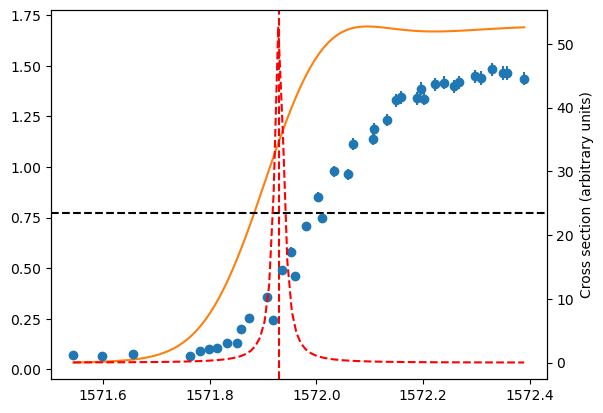

In [8]:
theta = list( params.valuesdict().values() )

grid = np.linspace( x.min( ), x.max( ), 100 )

mod = model( grid, theta )
cross = cross_section( grid, theta, theta[2] )

plt.errorbar( data[:, 0], data[:, 1], yerr=data[:, 2], fmt='o' )
plt.plot( grid, mod, '-' )

plt.axvline( theta[2], color='r', linestyle='--', label='Resonance' )

ymin, ymax = min( data[:, 1] ), max( data[:, 1] )
ymean = ( ymin + ymax ) / 2
plt.axhline( ymean, color='k', linestyle='--', label='Mean' )

# Plot cross section on secondary y-axis
ax2 = plt.gca().twinx()
ax2.plot( grid, cross, 'r--', label='Cross section' )
ax2.set_ylabel('Cross section (arbitrary units)')

#ax2.set_yscale('log')

plt.show( )

In [ ]:
out = minimize(chi2, params, method="least_squares")

print(f'Nvars {out.nvarys}              Ndata {out.ndata}')
print(f'Chi2 {out.chisqr:11.5f}     Chi2 / Ndof {out.redchi:11.5f}')

theta, error = [], []
print("----------------------------------------")
print('Parameter    Value       Stderr')
for name, param in out.params.items():
    theta.append( param.value )
    error.append( param.stderr )
    if( param.stderr == None ): param.stderr = 0
    print(f'{name:7s} {param.value:11.5f} {param.stderr:11.5f}')

In [ ]:
# Sample the theta 1 with a gaussian of 0.02 and calculate the 1 sigma spread
nsamples = 100

samples = np.zeros( shape=(nsamples, len(grid)) )
for i in tqdm( range( nsamples ) ):
    theta_new = theta.copy()
    for k in range( len( theta ) ):
        # If fixed, skip
        if( error[k] == 0 ): continue
        theta_new[k] = np.random.normal( theta[k], error[k] )
    samples[i] = model( grid, theta_new )

mean = np.mean( samples, axis=0 )
std  = np.std( samples, axis=0 )

100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


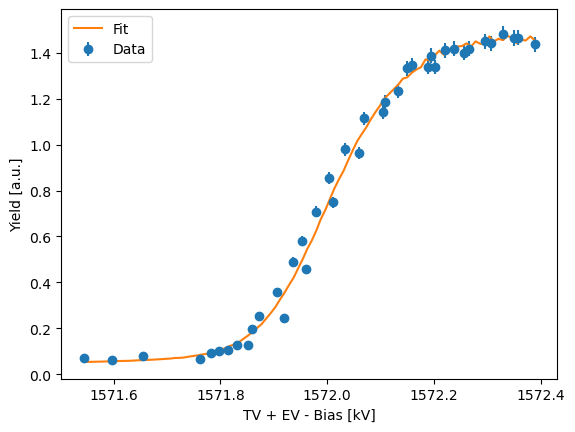

In [ ]:
mod = model( grid, theta )

plt.errorbar( data[:, 0], data[:, 1], yerr=data[:, 2], fmt='o', label="Data" )
plt.plot( grid, mod, '-', label="Fit" )
#plt.plot( grid, mean, '-', label="Mean" )
#plt.fill_between( grid, mean - std, mean + std, color="tab:orange", alpha=0.5, label="1$\sigma$")

plt.legend( )

plt.xlabel( "TV + EV - Bias [kV]" )
plt.ylabel( "Yield [a.u.]" )

plt.savefig( "results/Fit_1587_2023.pdf" )

In [ ]:
# Print curve to txt file
with open( "results/Fit_1587_2023.txt", "w" ) as f:
    for i in range( len( grid ) ):
        f.write( "{:10.4f} {:10.10f}\n".format( grid[i], mod[i] ) )

In [ ]:
# Load the data skipping the header
data = np.loadtxt( 'data/Data_1587_2024.txt', skiprows=1 )
x, obs, err = data[:,0], data[:,1], data[:,2]

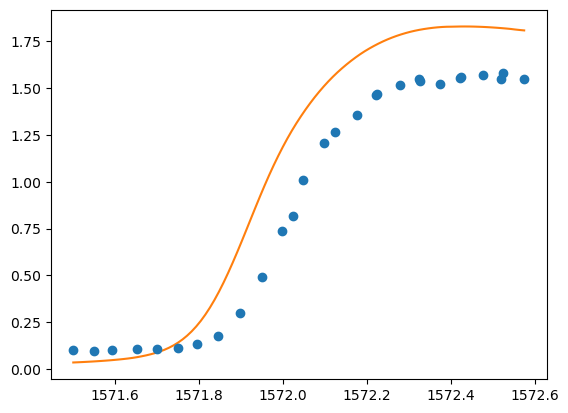

In [ ]:
theta = list( params.valuesdict().values() )

grid = np.linspace( x.min( ), x.max( ), 100 )

mod = model( grid, theta )

plt.errorbar( data[:, 0], data[:, 1], yerr=data[:, 2], fmt='o' )
plt.plot( grid, mod, '-' )

plt.show( )

In [ ]:
out = minimize(chi2, params, method="least_squares")

print(f'Nvars {out.nvarys}              Ndata {out.ndata}')
print(f'Chi2 {out.chisqr:11.5f}     Chi2 / Ndof {out.redchi:11.5f}')

theta, error = [], []
print("----------------------------------------")
print('Parameter    Value       Stderr')
for name, param in out.params.items():
    theta.append( param.value )
    error.append( param.stderr )
    if( param.stderr == None ): param.stderr = 0
    print(f'{name:7s} {param.value:11.5f} {param.stderr:11.5f}')

Nvars 7              Ndata 28
Chi2    51.48996     Chi2 / Ndof     2.45190
----------------------------------------
Parameter    Value       Stderr
beam        0.07000     0.00000
width       0.00227     0.00048
edge1    1572.02303     0.00014
height1     0.20570     0.00144
edge2       0.37904     0.04065
height2     0.21352     0.00222
slope      41.05857    55.59462
scale       1.00000     0.00000
back1       0.09349     0.00226


In [ ]:
# Sample the theta 1 with a gaussian of 0.02 and calculate the 1 sigma spread
nsamples = 100

samples = np.zeros( shape=(nsamples, len(grid)) )
for i in tqdm( range( nsamples ) ):
    theta_new = theta.copy()
    for k in range( len( theta ) ):
        # If fixed, skip
        if( error[k] == 0 ): continue
        theta_new[k] = np.random.normal( theta[k], error[k] )
    samples[i] = model( grid, theta_new )

mean = np.mean( samples, axis=0 )
std  = np.std( samples, axis=0 )

100%|██████████| 100/100 [01:05<00:00,  1.54it/s]


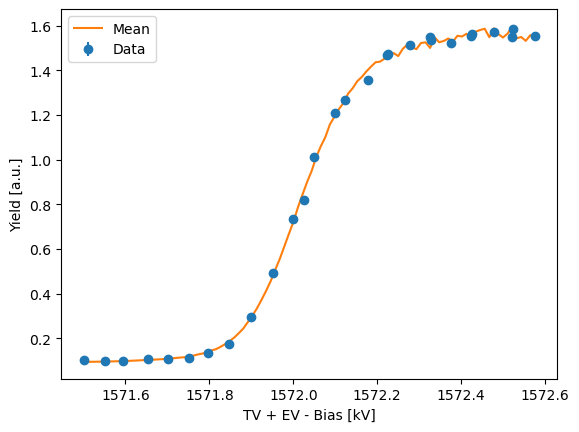

In [ ]:
mod = model( grid, theta )

plt.errorbar( data[:, 0], data[:, 1], yerr=data[:, 2], fmt='o', label="Data" )
plt.plot( grid, mod, '-', label="Mean" )
#plt.fill_between( grid, mean - std, mean + std, color='tab:orange', alpha=0.5 )

plt.legend( )

plt.xlabel( "TV + EV - Bias [kV]" )
plt.ylabel( "Yield [a.u.]" )

#plt.text( 625, 6, r'$\chi ^2 _r$: {:10.4f}'.format( out.redchi ) )

plt.savefig( "results/Fit_1587_2024.pdf" )

In [ ]:
# Print curve to txt file
with open( "results/Fit_1587_2024.txt", "w" ) as f:
    for i in range( len( grid ) ):
        f.write( "{:10.4f} {:10.10f}\n".format( grid[i], mod[i] ) )

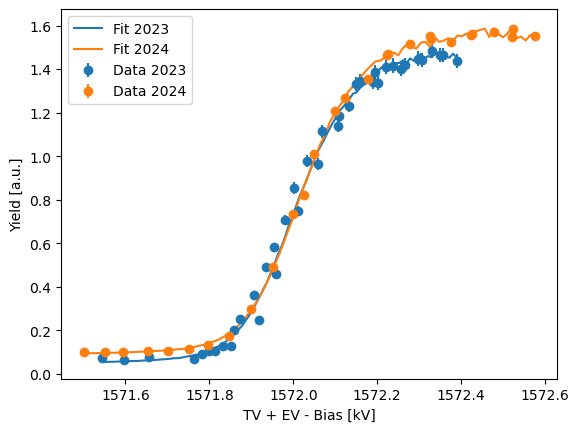

In [ ]:
# Load all the fits
mod_2023 = np.loadtxt( "results/Fit_1587_2023.txt", skiprows=1 )
mod_2024 = np.loadtxt( "results/Fit_1587_2024.txt", skiprows=1 )

# Load all the data
data_2023 = np.loadtxt( 'data/Data_1587_2023.txt', skiprows=1 )
data_2024 = np.loadtxt( 'data/Data_1587_2024.txt', skiprows=1 )

# Plot the data
plt.errorbar( data_2023[:, 0], data_2023[:, 1], yerr=data_2023[:, 2], fmt='o', label="Data 2023", color='tab:blue' )
plt.errorbar( data_2024[:, 0], data_2024[:, 1], yerr=data_2024[:, 2], fmt='o', label="Data 2024", color='tab:orange' )

plt.plot( mod_2023[:, 0], mod_2023[:, 1], '-', label="Fit 2023", color='tab:blue' )
plt.plot( mod_2024[:, 0], mod_2024[:, 1], '-', label="Fit 2024", color='tab:orange' )

plt.xlabel( "TV + EV - Bias [kV]" )
plt.ylabel( "Yield [a.u.]" )

plt.legend( )
plt.savefig( "results/Fit_1587.pdf" )